In [1]:
# Setup: Imports, Pfade und Parameter
import os
import sqlite3
import io
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Optional: scipy verwenden für spectrogram (Fallback zu matplotlib.specgram falls scipy fehlt)
use_scipy = True
try:
    from scipy import signal
except Exception as e:
    use_scipy = False

# Pfad zur DB (relativ zum Notebook-Standort). Bei Bedarf anpassen.
DB_PATH = 'batcallsv14.db'  # Falls Datei nicht gefunden wird, setze hier 'Projekt/batcallsv14.db'
# Ausgabeordner (relativ zum Notebook-Ordner)
#OUT_WAV_DIR = Path('export_wavs')
OUT_WAV_DIR = Path.home()/'Documents'/'OTH'/'KI3'/'ML'/'Projekt'/'export_wavs'
OUT_SPECT_DIR = Path.home()/'Documents'/'OTH'/'KI3'/'ML'/'Projekt'/'Spektrogramme'
OUT_WAV_DIR.mkdir(parents=True, exist_ok=True)
OUT_SPECT_DIR.mkdir(parents=True, exist_ok=True)

# Parameter
SAMPLE_RATE = 44100  # Hz (anpassen falls bekannt)
MAX_EXPORT = None  # setze auf int um nur N Dateien zu exportieren (zum Testen)

print('DB_PATH =', DB_PATH)
print('Export WAVs ->', OUT_WAV_DIR.resolve())
print('Spektrogramme ->', OUT_SPECT_DIR.resolve())
print('Using scipy.signal for spectrogram:', use_scipy)
print('Wenn die DB nicht im Notebook-Ordner liegt, passe DB_PATH an (z.B.).')

DB_PATH = batcallsv14.db
Export WAVs -> /Users/maass/Documents/OTH/KI3/ML/Projekt/export_wavs
Spektrogramme -> /Users/maass/Documents/OTH/KI3/ML/Projekt/Spektrogramme
Using scipy.signal for spectrogram: True
Wenn die DB nicht im Notebook-Ordner liegt, passe DB_PATH an (z.B.).


In [2]:
# Kurzer Probelauf & Inspektion: Tabellen, Spalten, ein Beispiel-Array laden
import pandas as pd
assert os.path.exists(DB_PATH), f"Datenbank nicht gefunden: {DB_PATH} (aktuelles Arbeitsverzeichnis: {os.getcwd()})"
conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql_query("SELECT name, type FROM sqlite_master WHERE type IN ('table','view') ORDER BY name;", conn)
print('Gefundene Tabellen:')
display(tables)

# Prüfe Schema der Tabelle 'batcalls' (sofern vorhanden)
if 'batcalls' in tables['name'].values:
    print('Schema batcalls:')
    display(pd.read_sql_query("PRAGMA table_info('batcalls');", conn))
else:
    raise SystemExit('Tabelle `batcalls` nicht gefunden in DB.')

# Lade eine Beispielzeile und inspiziere das arr-Blob
cur = conn.cursor()
cur.execute("SELECT call,target,id,bat,db,arr FROM batcalls LIMIT 1;")
row = cur.fetchone()
if row is None:
    raise SystemExit('Keine Zeilen in `batcalls` gefunden.')
call, target, _id, bat, db, blob = row
print('Beispiel: call, target, id, bat, db =', call, target, _id, bat, db)

# Blob -> numpy array versuchen
if isinstance(blob, memoryview):
    blob = bytes(blob)
arr = None
try:
    arr = np.load(io.BytesIO(blob), allow_pickle=False)
    print('np.load erfolgreich: shape=', arr.shape, 'dtype=', arr.dtype)
except Exception as e:
    print('np.load fehlgeschlagen:', e)
    try:
        arr = np.frombuffer(blob, dtype=np.int16).copy()
        print('frombuffer -> dtype=int16, len=', arr.shape)
    except Exception as e2:
        raise RuntimeError('Konnte arr-Blob nicht in numpy-array konvertieren: ' + str(e2))

# Darstellung Kurzinfo
print('Beispiel-Array: min,max,mean =', float(np.min(arr)), float(np.max(arr)), float(np.mean(arr)))
print('Beispiel-Array Länge (Samples) =', arr.shape[0])

# Optional: schließe die Verbindung hier nicht (wird im Export-Cell verwendet)
# conn.close()

Gefundene Tabellen:


,name,type
0,batcalls,table


Schema batcalls:


,cid,name,type,notnull,dflt_value,pk
0,0,call,INTEGER,0,None,0
1,1,target,INTEGER,0,None,0
2,2,id,INTEGER,0,None,0
3,3,bat,TEXT,0,None,0
4,4,arr,array,0,None,0
5,5,db,TEXT,0,None,0


Beispiel: call, target, id, bat, db = 38818 0 0 Bartfledermaus skiba
np.load erfolgreich: shape= (4410,) dtype= int16
Beispiel-Array: min,max,mean = -1808.0 1941.0 0.037868480725623585
Beispiel-Array Länge (Samples) = 4410


Gefundene Einträge: 51719)


KeyboardInterrupt: 

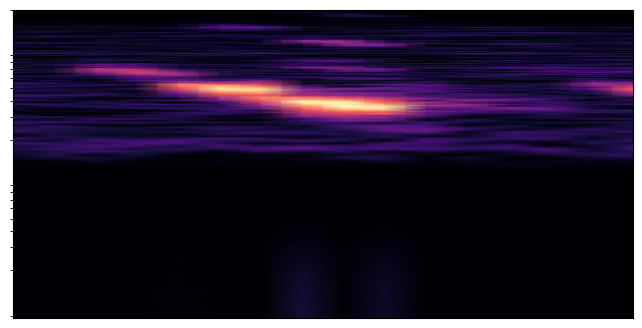

In [ ]:
# Export-Schleife: schreibe Spektrogramme für alle Einträge
import wave
import contextlib
from datetime import datetime
import math
from scipy.io import wavfile as _wavfile

num_calls = 0
cur = conn.cursor()
cur.execute(f"SELECT call,target,id,bat,db,arr FROM batcalls LIMIT {num_calls};")
rows = cur.fetchall()
n = len(rows)
print(f'Gefundene Einträge: {n})')

count = 0
count = 0
for r in rows:
    call, target, _id, bat, db, blob = r
    if isinstance(blob, memoryview):
        blob = bytes(blob)
    try:
        arr = np.load(io.BytesIO(blob), allow_pickle=False)
    except Exception:
        arr = np.frombuffer(blob, dtype=np.int16).copy()

    # wenn nötig in 1D float für spectrogramm umwandeln
    if arr.ndim != 1:
        arr = arr.flatten()
    # optional cast to float 
    arr_proc = arr.astype(np.float32)
    if np.issubdtype(arr.dtype, np.integer):
        arr_proc = arr_proc / np.iinfo(arr.dtype).max  # normalize -1..1 approx

    # Dateinamen
    safe_bat = ''.join(c for c in str(bat) if c.isalnum() or c in (' ','_','-')).strip().replace(' ','_')
    base_name = f"{_id}_call{call}_t{target}_{safe_bat}_{count}"
    spect_path = OUT_SPECT_DIR / (base_name + '.png')

    # skip, wenn Datei schon existiert
    if spect_path.exists():
        count += 1
        if MAX_EXPORT is not None and count >= MAX_EXPORT:
            break
        continue

    # Spektrogramm erzeugen und speichern (log y-axis)
    try:
        plt.figure(figsize=(8,4))
        ax = plt.gca()
        if use_scipy:
            freqs, times, Sxx = signal.spectrogram(arr_proc, fs=SAMPLE_RATE, nperseg=512, noverlap=256)
            Sdb = 10 * np.log10(Sxx + 1e-10)
            mesh = ax.pcolormesh(times, freqs, Sdb, shading='gouraud', cmap='magma')
            ax.set_yscale('log')
            ax.set_ylim(max(freqs[1], 20), min(SAMPLE_RATE/2, 20000))
        else:
            Pxx, freqs, bins, im = plt.specgram(arr_proc, NFFT=512, Fs=SAMPLE_RATE, noverlap=256, cmap='magma')
            mesh = im
            ax.set_yscale('log')
            ax.set_ylim(max(freqs[1], 20), min(SAMPLE_RATE/2, 20000))

        # Entferne Titel/Achsenbeschriftungen
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])

        plt.tight_layout(pad=0)
        plt.savefig(str(spect_path), dpi=150, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print('Fehler beim Erzeugen des Spektrogramms für', base_name, e)

    count += 1
    if count % 50 == 0:
        from datetime import datetime
        print(f'{datetime.now().isoformat()} - {count}/{n} exportiert')
    if MAX_EXPORT is not None and count >= MAX_EXPORT:
        print('Max export erreicht:', MAX_EXPORT)
        break

print(f'Export fertig: {count} Spektrogramme geschrieben.')
conn.close()

**Hinweise / nächste Schritte**
- weiter verarbeiten mit `librosa.load` 
- Für ML-Pipelines: aus den WAVs MFCCs oder Mel-Spectrograms zu berechnen und als Features in einer CSV/NPY abzulegen